In [ ]:
pip install --upgrade pip   

In [ ]:
pip install -U langgraph langchain_openai

In [1]:
import os

In [2]:
model_name = "gpt-4o-mini"  #gpt-4o-mini #gpt-3.5-turbo

In [3]:
from typing import List
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage
from pydantic import BaseModel, Field

In [4]:
from tempfile import TemporaryDirectory
from langchain_community.agent_toolkits import FileManagementToolkit

file_stores = FileManagementToolkit(
    selected_tools=["read_file", "write_file", "list_directory"], #use current folder
).get_tools()

read_file, write_file, list_file = file_stores

### Define State

In [5]:
TestLeadPrompt = """
**Role:** Regression Test Lead
**Task:** Collect information from user that helps to develop a high level design document also known as Macro Design Document \
for a software or application. 

You will receive following **pre-requisites** or **inputs**, \
1. Requirement document - {SRS} - contains use cases requirements, personas, non-functional requirements, \
use case interation diagram and others. \
2. High level design - {HLD} - contains design, best practices, guidelines and others. \

IMP: If any details are unclear or missing, you must ask the user for clarification. \
Do not proceed without resolving these uncertainties or unknowns. \
In case if you are making assumption, you must validate your assumptions with user and \
must get their confirmation before proceed.

**Clarification Strategy:**
- Your goal is, you must obtain all necessary information from user, \
that requires to build complete end to end regression test cases, \
- Ensure the questions are clear and focused on what is essential to generate test cases for regression testing \
- You may ask a set of questions at one time or one by one. \
You make a choice based on complexity of applicaiton or software and number of questions.

IMP: Restating again, you must proceed only after validating your understanding with user and getting their confirmaton.

**Steps:**

1. Identify missing or unclear details.
2. Ask for clarification and additional information from the user as necessary.
3. Verify your understanding with the user before proceeding to the next steps of creating test cases for regression testing.
4. Must ensure you understand 100% before calling the relevant tool.

"""

def get_messages_info(messages, srs, hld):
    return [SystemMessage(content=TestLeadPrompt.format(SRS=srs, HLD=hld))] + messages

class RegressionTestCase(BaseModel):
    """Instructions on how to prompt the LLM."""
    requirements: str
    additional_features: str
    business_domain: str
    architecture_style: str
    technology_choice: str
    architecture_decisions: str
    known_issues: str
    others: str 

llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)
llm_with_tool = llm.bind_tools([RegressionTestCase])

def information_gathering(state):
    messages = get_messages_info(state["messages"], state["srs"], state["hld"])

    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

def is_clarified(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "yes" #"clarified"

    else:
        return "no" #"need more information"

In [6]:
def conclude_conversation(state):
    return {
        "messages": [
            ToolMessage(
                content="Clarified and proceeding further",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

In [7]:
TesterPrompt = '''
**Role**: You are a Tester. You need to build test cases for regression testing.
**Task**: As a software tester, you are required to generate test cases for regression testing \
based on provided inputs by test lead. 

**Deliverables**
- Test Case ID: [Unique ID, e.g., TC_UI_01]
- Title: [Short Title, e.g., "Verify Login with Valid Credentials"]
- Description: [Brief objective of the test case]
- Preconditions: [List any setup required before executing the test]
- Test Steps:
	1. [Step 1: Navigate to the login page]
	2. [Step 2: Enter valid username]
	3. [Step 3: Enter valid password]
	4. [Step 4: Click the "Login" button]
- Test Data: [List required input values, e.g., Username: user@example.com; Password: Pasxxxx3]
- Expected Result: [Describe the anticipated outcome, e.g., "User is redirected to the dashboard"]
- Remarks: [Any additional notes]


IMP: 
- Always, You should do self-critique by validating generated deliverables with provided SRS, HLD and additional information from Test Lead. \
- When critique or feedback received, ensure you thoroughly analyze and understand the feedback, then \
you must incorporate critique / feedback on previous version of test cases, share revised test cases to Reviewer. \
also ensure you are not lossing any existing sections and contents.
- your deliverables must match more than 95% with SRS, HLD, and Additiona information from Test Lead.

Additional information shared by Test Lead: {reqs}
'''


def get_prompt_messages(messages: list, state):
    tool_call = None
    other_msgs = []
    
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)

   
    iteration = state['iteration']
    
    rtc = state.get('rtc')
    if rtc:
        print("***** Revision Number ****", iteration)
        return[
            SystemMessage(content=TesterPrompt),
            HumanMessage(content=state['messages'][-1].content + state['rtc'][-1].content  + state['hld'][-1].content + state['srs'][-1].content)]
    else:
        return[
            SystemMessage(content=TesterPrompt.format(reqs=tool_call)),
            HumanMessage(content=state['srs'][-1].content)
            ] + other_msgs 

def generate_rtc(state):
    
    messages = get_prompt_messages(state["messages"], state)
    
    response = llm.invoke(messages)
    iteration = str(state['iteration'])
    file_name = "output/rtc v0." + iteration +".md"
    
    write_file.invoke({"file_path": file_name, "text": response.content})

    return {
        "messages": [response] ,
        "rtc": [response],
        
    }

In [8]:
critique = """
**Role:** Senior Tester
**Task:** You are a critic, who analyze requirement, design and ensure test cases for regression testing is complete. \
You are tasked to Analyze provided {hld}, {srs} and {rtc}.

**Highlight findings as below**
- Alignments
- Mismatches
- % of match between SRS, HLD and RTC

"""

def get_feedback_info(hld, srs, rtc):
    return [SystemMessage(content=critique)] + hld + srs + rtc

llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)

def approver(state):
    hld = state['hld']
    srs = state['srs']
    rtc = state['rtc']
    messages = get_feedback_info(hld, srs, rtc)
    

    response = llm.invoke(messages)
    max_iteration = state['max_iteration']
    iteration = state['iteration'] + 1
    
    return {
        "messages": [response],
        "iteration": iteration
    }

In [9]:
def is_approved(state):
    max_iteration = state['max_iteration']
    iteration = state['iteration']
   
    if iteration > max_iteration:
        return 'approved'
    else:
        return 'enhance'

In [10]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END

class State(TypedDict):
    messages: Annotated[list, add_messages]
    srs: Annotated[list, add_messages]
    hld: Annotated[list, add_messages]
    rtc: Annotated[list, add_messages]
    max_iteration: int
    iteration: int
    #do_nothing: str
    
    
memory = MemorySaver()
workflow = StateGraph(State)

workflow.add_edge(START, "information_gathering")

workflow.add_node("information_gathering", information_gathering)
workflow.add_node("conclude_conversation", conclude_conversation)
workflow.add_conditional_edges(
    "information_gathering", 
    is_clarified, 
    {"yes": "conclude_conversation",  "no": END}
)
workflow.add_node("generate_rtc", generate_rtc)

workflow.add_edge("conclude_conversation", "generate_rtc")
#workflow.add_edge("generate_rtc", END)

workflow.add_node("approver",approver)
workflow.add_conditional_edges(
    "approver", 
    is_approved, 
    {"approved": END, "enhance": "generate_rtc"}
)


workflow.add_edge("generate_rtc", "approver")

graph = workflow.compile(checkpointer=memory) #, interrupt_after=['generate_requirements'])

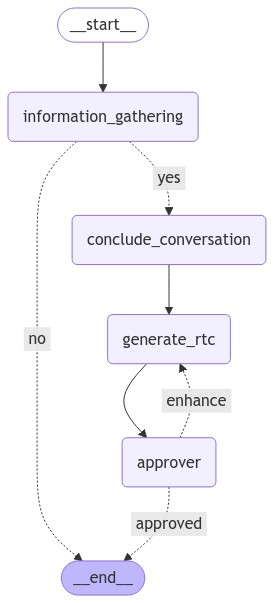

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
thread = {"configurable": {"thread_id": 12}}
SRS = read_file.invoke({"file_path": "input/srs.md"})
HLD = read_file.invoke({"file_path": "input/hld.md"})
#print(readfile)

count = 1

while True:
    user = input("User (q/Q to quit): ")
    if user.lower() in ["quit", "q", "Q"]:
        print("AI: Byebye")
        break
    output = None
    
    #print(count)
    #user_msg = user + " \n SRS" + SRS
    #print(count)    
    for output in graph.stream(
        {
            "messages": [HumanMessage(content=user)],
            "srs": [HumanMessage(content=SRS)],
            "hld": [HumanMessage(content=HLD)],
            "iteration" : 1,
            "max_iteration": 3,
        }, 
        config=thread, 
        stream_mode="updates"):
        #print(output)
        for key, value in output.items():
            print("***** Result from Agent: ",key)
            #print("***** value: ",value)
            
            try:
                last_message = next(iter(output.values()))["messages"][-1]
                last_message.pretty_print()
            except:
                print("pass")



User (q/Q to quit):  write test cases for given SRS and hld


***** Result from Agent:  information_gathering
================================== Ai Message ==================================

Before I proceed to create regression test cases based on the provided Software Requirements Specification (SRS) and High-Level Design (HLD) documents, I need to clarify a few details to ensure that I fully understand the requirements and can create comprehensive test cases.

1. **Business Domain**: Can you confirm the business domain for this application? Is it strictly for task management, or does it have a broader context (e.g., project management, team collaboration)?

2. **Additional Features**: Are there any additional features or functionalities that are not mentioned in the SRS or HLD that should be included in the test cases?

3. **Known Issues**: Are there any known issues or limitations in the current implementation that should be considered while writing the test cases?

4. **Architecture Decisions**: Are there any specific architectural decision

User (q/Q to quit):  1. It's for task Management, 2. No additional features, 3. No known issues for now, 4. all covered in Hld, 5. Nope


***** Result from Agent:  information_gathering
================================== Ai Message ==================================

Thank you for the clarifications! Here's a summary of the information I have:

1. **Business Domain**: Task Management
2. **Additional Features**: None
3. **Known Issues**: None for now
4. **Architecture Decisions**: All covered in HLD
5. **Technology Choice**: No specific focus, consider the entire technology stack mentioned in the HLD

With this understanding, I will proceed to create the regression test cases based on the provided SRS and HLD. 

I'll now generate the test cases.
Tool Calls:
  RegressionTestCase (call_ebAlvHlqoFLcXTHRFkybyS37)
 Call ID: call_ebAlvHlqoFLcXTHRFkybyS37
  Args:
    requirements: The web application will allow users to create and manage tasks, assign tasks to users or teams, track the status of tasks through predefined statuses (e.g., Open, In Progress, Completed), receive notifications for updates on tasks, and generate report

User (q/Q to quit):  q


AI: Byebye


User (q/Q to quit):  1. Include all, 2. no, 3. for distribution industry, 4. no, 5. no, 6. no, 7. no


***** Result from Agent:  information_gathering
================================== Ai Message ==================================

Thank you for the clarifications. To summarize:

1. **Requirements Coverage**: All functional requirements from the SRS document will be included in the regression test cases.
2. **Additional Features**: There are no additional features to consider.
3. **Business Domain**: The application is intended for the distribution industry.
4. **Architecture Style**: No specific architectural decisions or patterns need to be considered.
5. **Technology Choice**: No specific technologies or tools for testing have been mentioned.
6. **Known Issues**: There are no known issues to consider.
7. **Others**: No additional information or specific scenarios need to be included.

With this understanding, I will proceed to create the regression test cases based on the provided requirements and design documents. 

Here are the key areas I will focus on for the regression test cas

User (q/Q to quit):  q


AI: Byebye
